In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy
from scipy.optimize import minimize
from statsmodels.regression.linear_model import OLS

In [8]:
def neg_loglik_cauchy(x, theta_guess):
    loglik = np.sum(np.log(1/np.pi) - np.log(1 + (x - theta_guess) ** 2))
    
    return -loglik

In [9]:
def neg_l_doubledots_cauchy(x, theta_hat):
    l_2dots = np.sum((4 * (x - theta_hat) ** 2 - 2 * (1 + (x - theta_hat) ** 2)) / ((1 + (x - theta_hat) ** 2)) ** 2)
    
    return - l_2dots

In [10]:
theta_hat_list = list()
obs_inf_bound_list = list()

In [11]:
for rep in range(1, 10000):
    cauchy_draws = cauchy.rvs(size=20)
    neg_shifted_cauchy_log_lik_for_x = lambda theta_guess: neg_loglik_cauchy(cauchy_draws, theta_guess)
    theta_hat = minimize(neg_shifted_cauchy_log_lik_for_x, 0, method='L-BFGS-B')['x'][0]
    theta_hat_list.append(theta_hat)
    obs_fish_inf_sample = neg_l_doubledots_cauchy(cauchy_draws, theta_hat)
    obs_information_bound = 1 / obs_fish_inf_sample 
    obs_inf_bound_list.append(obs_information_bound)

(array([6.000e+00, 7.000e+00, 6.900e+01, 6.970e+02, 3.258e+03, 4.413e+03,
        1.370e+03, 1.640e+02, 1.300e+01, 2.000e+00]),
 array([-2.0791397 , -1.67795077, -1.27676185, -0.87557293, -0.47438401,
        -0.07319509,  0.32799384,  0.72918276,  1.13037168,  1.5315606 ,
         1.93274952]),
 <a list of 10 Patch objects>)

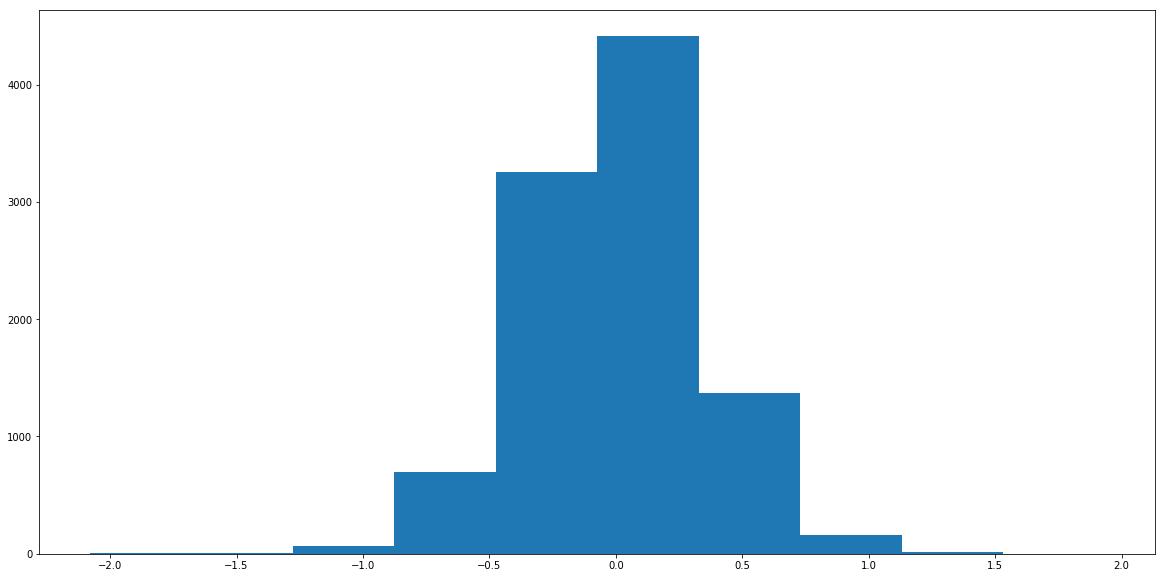

In [12]:
plt.figure(figsize=(20,10))
plt.hist(theta_hat_list)

In [13]:
inf_bound_df = pd.DataFrame({'observed_inf_bound': obs_inf_bound_list})
quintiles = np.quantile(obs_inf_bound_list, np.linspace(0.05,1,20))
inf_bound_df['bin_number'] = np.digitize(obs_inf_bound_list, quintiles, right=True)
inf_bound_df['theta_hat'] = theta_hat_list
inf_bound_df = inf_bound_df.groupby('bin_number').agg({'observed_inf_bound':'mean', 'theta_hat':'var'}) \
                           .rename(columns={'theta_hat': 'theta_hat_variance'})

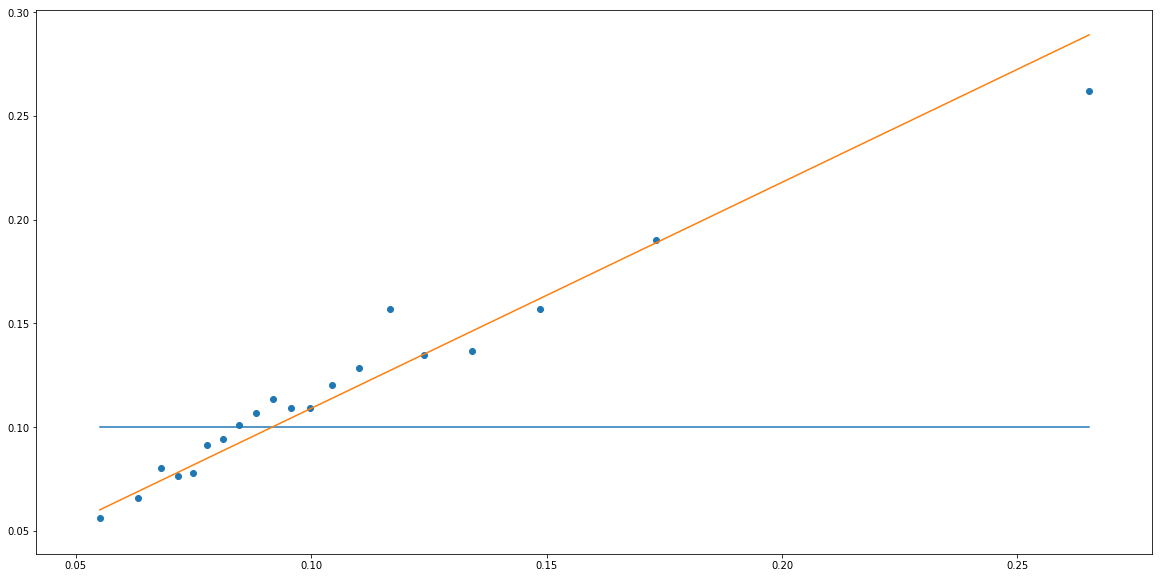

In [14]:
plt.figure(figsize=(20,10))
plt.scatter(inf_bound_df['observed_inf_bound'], inf_bound_df['theta_hat_variance'])
plt.plot(inf_bound_df['observed_inf_bound'], np.repeat(0.1, 20)) # Unconditional Fisher information bound
plt.plot(inf_bound_df['observed_inf_bound'], OLS(inf_bound_df['theta_hat_variance'], 
                                                inf_bound_df['observed_inf_bound']).fit().predict()) # Trend of conditional Fisher information bound